## Gradient Boosting

In this notebook, you will use [scikit-learn's regression trees](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) and implement the gradient boosting algorithm for least squares regression. In particular, you will:

1. Implement gradient boosting with shrinkage and evaluate its performance on the boston housing data set.
2. Investigate the effect of number of iterations and tree depth.
3. Plot the additive structure of gradient boosting.

The exercise is mostly based on the lecture and the following book:

T. Hastie, R. Tibshirani, and J. Friedman: [*The Elements for Statistical Learning*](http://statweb.stanford.edu/~tibs/ElemStatLearn/), 2001

As usual, some setup first:

In [1]:
import sklearn.cross_validation
import sklearn.datasets
import sklearn.dummy
import sklearn.tree
import sklearn.base
import sklearn.metrics
import sklearn.ensemble

import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

/home/eggenspk/miniconda3/envs/general_36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load the boston housing dataset
def create_dataset():
    
    boston = sklearn.datasets.load_boston()
    X = boston.data
    y = boston.target
    X_train, X_test, y_train, y_test = \
        sklearn.cross_validation.train_test_split(X, y, random_state=1)
    return X_train, y_train, X_test, y_test

In [3]:
class GradientBoosting(object):
    
    def __init__(self, iterations, learning_rate=1.0):
        # Some global variables
        self.iterations = iterations
        self.classifiers = list()
        self.weak_learner = sklearn.tree.\
            DecisionTreeRegressor(max_depth=1)
        self.learning_rate = learning_rate
    
    # derivative of L2 loss
    def _delta_l(self, y_true, f_of_x):
        return y_true - f_of_x
    
    def fit(self, X, y):
        # 1. Initialize f_0
        # hint: Scikit-learn offers dummy predictors 
        # (e.g. DummyRegressor), which return constant 
        # predictions according to a simple, user-defined rule
        f_0 = sklearn.dummy.DummyRegressor(strategy='mean')
        f_0.fit(X, y)
        self.classifiers.append(f_0)
        
        f_of_x = f_0.predict(X)
        
        # 2. For m = 1 to m
        for iteration in range(self.iterations):

            # 2.a) compute pseudo residuals
            generalized_residuals = self._delta_l(y, f_of_x)

            # 2.b) fit regression tree to the residuals
            # 2.c) update terminal region: not necessary for 
            #      squared loss
            f_m = sklearn.base.clone(self.weak_learner)
            f_m.fit(X, generalized_residuals)

            # 2.d) update f_of_x
            f_of_x += self.learning_rate*f_m.predict(X)
            self.classifiers.append(f_m)
            
        return self
    
    def predict(self, X):
        predictions = self.classifiers[0].predict(X)
        for classifier in self.classifiers[1:]:
            predictions += self.learning_rate*classifier.predict(X)
        
        return predictions
    
    def staged_predict(self, X):
        # returns predictions for X for all iterations 
        # this is for convenience to simplify computing
        # train/test error for all models

        staged_predictions = []
        pred = self.classifiers[0].predict(X)
        staged_predictions.append(pred.copy())
        for classifier in self.classifiers[1:]:
            pred += self.learning_rate*classifier.predict(X)
            staged_prediction = pred.copy()         
            staged_predictions.append(staged_prediction)
            
        return staged_predictions

**Note**: As you use *squared loss* there is no need to update the terminal regions in each leaf as the values in the leaves of decision trees already are optimal constant to minimize squared loss. With other loss functions you would need to update the leaf-values, such as done in sklearn:

https://github.com/scikit-learn/scikit-learn/blob/51a765a/sklearn/ensemble/gradient_boosting.py#L792

such as minimizing the least absolute error here:

https://github.com/scikit-learn/scikit-learn/blob/51a765a/sklearn/ensemble/gradient_boosting.py#L321

### Test your implementation
Now, you have a working implementation of the gradient boosting algorithm. 

To test your algorithm for correctness you can compare to [sklearn's gradient boosting implementation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) which should yield the same output as your implementation:

In [4]:
# Use this cell to test whether your implementation is correct

gbm = GradientBoosting(iterations=400, learning_rate=1.0)
sk_gbm = sklearn.ensemble.GradientBoostingRegressor(
    n_estimators=400, learning_rate=1.0, max_depth=1)

# Get data
X_train, y_train, X_test, y_test = create_dataset()

# Fit model
gbm.fit(X_train, y_train)
sk_gbm.fit(X_train, y_train)

# Predict
pred = gbm.predict(X_test)
pred_sk = sk_gbm.predict(X_test)

print("Difference: %d" % np.sum([pred - pred_sk]))

Difference: 0


###  Add shrinkage

The scikit-learn implementation offers a parameter 'learning_rate' which implements skrinkage, such that the contribution of each model is shrinked. This means the adaption to the target function is slowed down and thus prevents gradient boosting from overfitting. Changing line (d) in the Pseudocode (see Algorithm 10.3 *Gradient Tree Boosting Algorithm*) from 

$f_m(x) = f_{m-1}(x) + \sum_{j=1}^{J_m} \gamma_{jm} {\bf I} (x \in R_{jm})$

to

$f_m(x) = f_{m-1}(x) + \nu \sum_{j=1}^{J_m} \gamma_{jm} {\bf I} (x \in R_{jm})$

will do this. Add a learning rate to your implementation of Gradient Boosting.

### Playground

Next, you can now play around with AdaBoost's hyperparameters. Here are some suggestions to try:

* Investigate the number of iterations that are needed to start overfitting.
* Add some noise on the targets and try again
* Investigate the effect of the tree depth
* Investigate effect of shrinkage

But first you should implement a plotting function to show train/test error over time:

In [5]:
def plot_train_test_error(model, X_train, y_train, X_test, y_test):
    ''' Shows a plot with train/test error over iterations

    model (GBM): trained GBM algorithm
    X_train (array): [#samples, #features]
    y_train (array): [#samples, ]
    X_test (array): [#samples, #features]
    y_test (array): [#samples, ]
    '''
    # YOUR TURN

    # Loop over all predictions and compute the mean squared error

    y_pred_train = model.staged_predict(X_train)
    training_errors = [sklearn.metrics.mean_squared_error(y_train, y_pred)
                       for y_pred in y_pred_train]
    
    y_pred_test = model.staged_predict(X_test)
    test_errors = [sklearn.metrics.mean_squared_error(y_test, y_pred)
                   for y_pred in y_pred_test]
    
    # Plot results
    x_values = np.arange(1, len(training_errors) + 1)

    plt.plot(x_values, training_errors, label="training")
    plt.plot(x_values, test_errors, label="test")
    plt.xlabel("iterations")
    plt.ylabel("MSE")
    plt.legend(loc="best")

    plt.show()

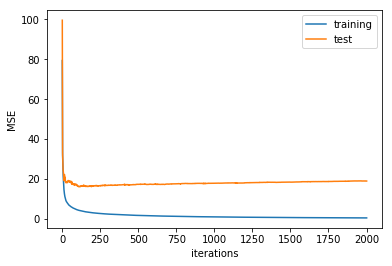

In [6]:
# The train and test error diverge after roughly ~15 iterations. 
# While the training error constantly decreases, test error raises 
# after ~200 iterations. With deeper trees, the test error can be 
# decreased to zero for the price of earlier overfitting on the test set.
# Adding noise with std=1 does harm the performance only slightly
# Adding noise with std=2 harms the performance quite a lot
# Adding more noise results also in increased overfitting
# A lower learning rate prevents overfitting and training error does 
# not decrease to 0

# YOUR TURN

# Get data
X_train, y_train, X_test, y_test = create_dataset()

# Instantiate model
gbm = GradientBoosting(iterations=2000, learning_rate=1)

# Fit model
gbm.fit(X_train, y_train)
pred = gbm.predict(X_test)

# Evaluate model
plot_train_test_error(gbm, X_train, y_train, X_test, y_test)

### Plot individual models
Finally, it's time to investigate the additive nature of gradient boosting. For this, we plot the prediction of the gradient boosting model for a sine curve after different amounts of iterations

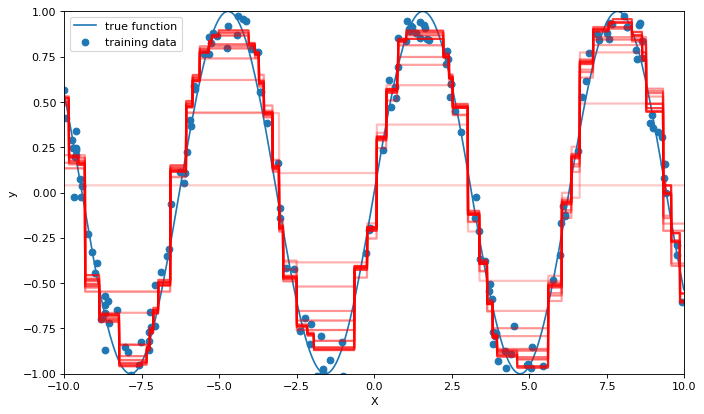

In [7]:
# Here's some training data:
np.random.seed(1)
num_data_points = 200
lower_bound = -10
upper_bound = 10
X = np.random.uniform(lower_bound, upper_bound, num_data_points)
X = X.reshape((-1, 1))
y = (np.sin(X) + np.random.randn(num_data_points).reshape((-1, 1)) * 0.1)
y = y.ravel()

true_function_X = np.arange(lower_bound, upper_bound, 0.01)
true_function_X = true_function_X.reshape((-1, 1))

plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', 
           edgecolor='k')
plt.scatter(X.ravel(), y, label="training data")
plt.plot(true_function_X, np.sin(true_function_X), 
         label='true function')
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc="best")
plt.ylim([-1, 1])
plt.xlim([lower_bound, upper_bound])

# YOUR TURN
# Plot a line for each model
iterations = 100
num_curves = 10

gbm = GradientBoosting(iterations=iterations,)
gbm.fit(X, y)
staged_predictions = gbm.staged_predict(true_function_X)

for i, prediction in enumerate(staged_predictions):
    if int(iterations / num_curves) != 0 and \
         i % int(iterations / num_curves) != 0:
        continue
        
    alpha = 0.2 + (i / len(staged_predictions) / 1.8)
    plt.plot(true_function_X, prediction, color='red', 
             linewidth=2, alpha=alpha)
    
plt.show()